## AskStreets: Query and Visualizing Street Networks using OSMnx, ArangoDB, and LangGraph
Author: Adam Munawar Rahman, 2025

Using powerful libraries like OSMnx, we can retrieve street networks and feature datasets from OpenStreetMap and persist them as graph and collections in ArangoDB. Then, with a  ReACT agent model, feed natural language queries to LLMs to execute complex lookups, run GPU backed graph algorithms, and visualize geospatial coordinates - all to enable streamlined insights into the network properties of the geographic area we are analyzing.

In [120]:
import json
import os
import random
import re
import time
import traceback
import yaml

import folium
import geopandas as gpd
import networkx as nx
import numpy as np
import nx_arangodb as nxadb
import osmnx as ox
import pandas as pd

from arango import ArangoClient
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
from geopy.geocoders import Nominatim
from IPython.display import Markdown, display

from langchain.tools import Tool
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_community.graphs import ArangoGraph
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

### I. Loading OpenStreetMap Networks and Features to ArangoDB
We can retrieve both street networks (consisting of nodes and edges representing the different types of paths that can be traversed between the geographic locations) and features (consisting of points associated with specific attributes like amenity type) by calling `OSMnx.graph_from_address` and `OSMnx.features_from_address`. 

In this instance, I'm using my workplace in NYC - IBM at One Madison - as the basis for building our reference data from.

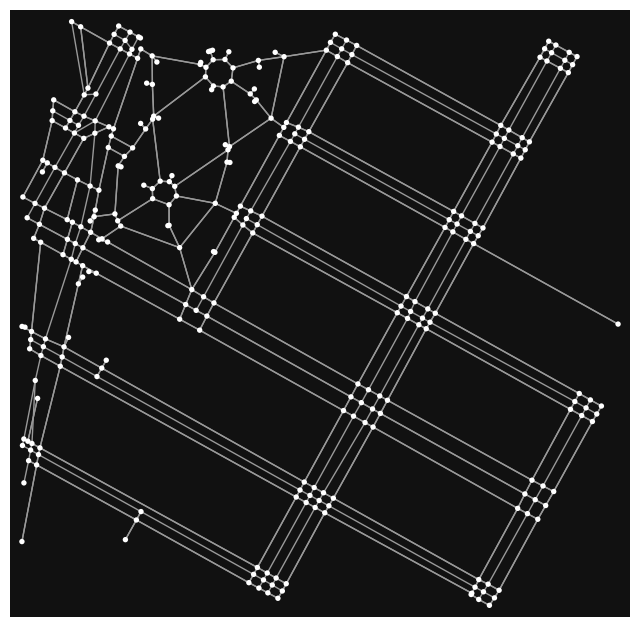

MultiDiGraph with 308 nodes and 854 edges


In [121]:
# Retrieve the street network using the built-in OSMnx function
# Code is commented out for expediency - it takes time to build the graph, so we'll save/load as .graphml
G_ox = ox.graph_from_address("1 Madison Ave, Manhattan, NY", dist=240.0)

# # Drop the shapely.Linestring attribute as it is not serializable to JSON, preventing ArangoDB persistence
for node1, node2, edge_dict in G_ox.edges(data=True):
    edge_dict.pop('geometry', None)

ox.plot_graph(G_ox)
print(G_ox)

In [122]:
sample_node = list(G_ox.nodes(data=True))[0]
print(f"Sample node data: {sample_node}")

sample_edge = list(G_ox.edges(data=True))[0]
print(f"Sample edge data: {sample_edge}")

Sample node data: (42428192, {'y': 40.7398722, 'x': -73.9895636, 'street_count': 4})
Sample edge data: (42428192, 12072425146, {'osmid': 803024464, 'highway': 'residential', 'lanes': '1', 'maxspeed': '25 mph', 'name': 'East 21st Street', 'oneway': True, 'width': '10', 'reversed': False, 'length': 7.530122679064509})


In [123]:
# Since the nodes in the OSMnx graph do not include the address, we geocode each node
# Code is commented out for expediency - it takes even more time to geocode each node, so we'll save/load as .graphml
geolocator = Nominatim(user_agent="osmnx_geocoder")
for node_id, node_data in G_ox.nodes(data=True):
    # Get the latitude and longitude
    lat = node_data['y']
    lon = node_data['x']
    
    try:
        # Use reverse geocoding to get address information
        location = geolocator.reverse(f"{lat}, {lon}", exactly_one=True)
        
        if location:
            # Add address information to the node
            G_ox.nodes[node_id]['address'] = location.address

        # Avoid possible rate limiting by waiting a bit between each node
        time.sleep(1)
        
    except Exception as e:
        print(f"Error geocoding node {node_id}: {e}")

sample_node = list(G_ox.nodes(data=True))[0]
print(f"Sample node data with address: {sample_node}")

Sample node data with address: (42428192, {'y': 40.7398722, 'x': -73.9895636, 'street_count': 4, 'address': 'Cha Cha Matcha, 922, Broadway, Flatiron District, Manhattan Community Board 5, Manhattan, New York County, City of New York, New York, 10010, United States'})


In [125]:
# The node identifiers change when persisting the graph to ArangoDB, so to allow the tools to better communicate with each other,
# e.g. when passing OSMNX results to the AQL tool, let's include current NetworkX node IDs so ArangoDB can access them
for node_id, node_data in G_ox.nodes(data=True):
    G_ox.nodes[node_id]['ID'] = node_id

In [126]:
filepath = "./data/madison.graphml"
ox.save_graphml(G_ox, filepath)

In [127]:
# Load street network graph from saved file
# G_ox = ox.io.load_graphml(filepath)
# ox.plot_graph(G_ox)
# print(list(G_ox.edges(data=True))[0])

In [128]:
# Load credentials, and define the OpenAI API key for later
credentials = yaml.load(open('credentials.yml'), Loader=yaml.SafeLoader)
os.environ["OPENAI_API_KEY"] = credentials["OPENAI_API_KEY"]

In [129]:
db = ArangoClient(hosts=credentials["DATABASE_HOST"]).db(
    username=credentials["DATABASE_USERNAME"],
    password=credentials["DATABASE_PASSWORD"],
    verify=True
)

In [130]:
# The OSM graph is a MultiDiGraph - i.e. a Directed Graph that continains nodes that can have multiple edges between them
# Let's make sure we persist it in ArangoDB as the same type
G_ox_adb = nxadb.MultiDiGraph(
    name="G_ox_adb",
    db=db,
    incoming_graph_data=G_ox,
    overwrite_graph=True
)
print(G_ox_adb)

# Jupyter Notebook occasionally misreports the graph has having 0 edges when loaded into ArangoDB
# Verify that the correct number of nodes and edges are there
print(f"True number of nodes in G_ox_adb is: {G_ox_adb.number_of_nodes()}")
print(f"True number of edges in G_ox_adb is: {G_ox_adb.number_of_edges()}")

[19:05:57 -0500] [INFO]: Overwriting graph 'G_ox_adb'
[19:05:57 -0500] [INFO]: Graph 'G_ox_adb' exists.
[19:05:57 -0500] [INFO]: Default node type set to 'G_ox_adb_node'
[2025/03/04 19:05:57 -0500] [16034] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database '_system'


Output()

Output()

[2025/03/04 19:05:57 -0500] [16034] [INFO] - adbnx_adapter: Created ArangoDB 'G_ox_adb' Graph


MultiDiGraph named 'G_ox_adb' with 308 nodes and 854 edges
True number of nodes in G_ox_adb is: 308
True number of edges in G_ox_adb is: 854


In [131]:
# Retrieve OpenStreet map features within the area of the street network that we just received
# Refer to https://wiki.openstreetmap.org/wiki/Map_features for the specific features

# Collecting a large number of tags improves the diversity of queries we can make!
tags = {'building': True, 'amenity': True, 'healthcare': True, 'office': True, 'public_transport': True, 'craft': True, 'historic': True}
features_gdf = ox.features.features_from_address("1 Madison Ave, Manhattan, NY", tags, 240.0)

In [132]:
# Add the features GeoDataFrame as an ArangoDB Collection so AQL can query it later
if db.has_collection('features'):
    db.delete_collection('features')
features_collection = db.create_collection('features')

# This is to avoid warnings given by geopandas regarding the centroid accuracy
# Some of the geometries in the GeoDataFrame returned by OSMnx are polygons 
# that give a bounding box for a particular feature

# To simplify the process so that each feature has an associated lat and long,
# we just return the centroid of the geometry instead
# e.g. for a bounding box, just return the center point 
# this will be sufficient for performing calculations on said feature

utm_crs = ox.projection.project_gdf(features_gdf).crs
features_gdf['lat'] = features_gdf.to_crs(utm_crs).centroid.to_crs(features_gdf.crs).y
features_gdf['lon'] = features_gdf.to_crs(utm_crs).centroid.to_crs(features_gdf.crs).x

features_gdf_adjusted = features_gdf.drop(columns=['geometry','type'])

features_json_str = features_gdf_adjusted.reset_index().to_json(orient='records')
features_records = json.loads(features_json_str)

features_collection.insert_many(features_records)
print(f"Added {len(features_records)} feature records to ArangoDB 'features' collection")

Added 432 feature records to ArangoDB 'features' collection


In [133]:
# Initialize ArangoGraph
arango_graph = ArangoGraph(db)

### II. Defining the LLM-based tools for the ReACT Agent App
In this portion of the code we define four tools:
1. `text_to_aql_to_text` - Generates ArangoDB Query Language based on the natural language query
2. `text_to_osmnx_algorithm_to_text` - Generates OSMnx/NetworkX Python code based on the natural language query
3. `text_to_geocoder_to_coordinates` - Extracts the geographic location from the natural language query and geocodes it
4. `text_to_coordinates_to_folium_map` - Extracts geospatial coordinates from the query and plots them on a Folium map

In [134]:
@tool
def text_to_aql_to_text(query):
    """
    Translates natural language to AQL, executes against Arango database, returns results as text.
    
    USE THIS TOOL WHEN:
    - Querying the graph in ArangoDB (nodes, edges, features collections)
    - Finding relationships/paths between locations or buildings
    - Performing aggregations, filters, or sorting on stored data
    - Looking up properties like names, addresses, or building types
    - Counting or listing street network elements with specific attributes
    
    DO NOT USE WHEN:
    - Working with the in-memory OSMnx graph object
    - Calculating network metrics like centrality or clustering
    - Performing advanced spatial operations
    """
    print(f"🔍 AQL Tool: Starting to process query: '{query}'")
    
    # Initialize the LLM
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    print(f"🔍 AQL Tool: Initialized LLM")

    # Enhance the query by adding context to the original question posed by the user
    # referencing the attributes of the graphs and collections store in ArangoDB
    
    schema_context = """
    You are an experienced graph network analyst proficient in writing ArangoDB Query Language.

    This query is about data with these collections:

    1. G_ox_adb_node: Street intersections with attributes:
    - x, y: Coordinates (longitude, latitude)
    - osmid: OpenStreetMap ID
    - highway: Type of intersection (junction, traffic_signals, etc.)
    - address: Real world location of the node
    - ID: The original ID from the NetworkX version of the graph

    2. G_ox_adb_edge: Street segments connecting intersections
    - length: length in meters
    - name: Street name
    - oneway: Boolean indicating if it's a one-way street

    3. features: Features of the area with attributes:
    - osmid: OpenStreetMap ID
    - element_type: 'node' or 'way'
    - the following OpenStreetMap feature tags
        - building: Boolean yes/no indicating if the feature is a building
        - amenity: The type of amenity the feature is e.g. cafe, bank
        - healthcare: The health specialty e.g. nurse, optometrist
        - office: The type of company the office is for e.g. financial, airline
        - public_transport: The type of public transport feature e.g. platform, station
        - craft: Describes the type of craft the feature is for e.g. bakery, jeweller
        - historic: Describes the type of historic site, e.g. house, memorial
    - name: Name of the feature
    - lat, lon: geospatial coordinates of the feature

    # TASK
    Generate executable AQL to answer this query. 
    
    If the query asks for a path to the nearest feature, first find a node on the graph that is closest to that feature, 
    then run the algorithm.

    If the query specifies node IDs, use the ID attribute of the node. 
    For example, if the query asks "Find the address of the intersection with node ID 247798296.", then use node.ID instead of node._key.

    If the query specifies a generic location type like 'cafe', 'office', 'subway' or 'bank', use the amenity attribute. 
    Use the other OpenStreetMap feature tags if the query is more specific.

    For example, if there is a building located at a certain latitude and longitude, and the query asks for a path to get to that building,
    first find a node in the graph that has the nearest straight line distance to that building, then use that node for the traversal algorithm.

    Focus on writing efficient AQL queries that:
    1. Use FILTER, SORT, LIMIT as needed to optimize performance
    2. Use graph traversals for finding paths and connections
    3. Return well-structured data that directly answers the question
    4. Include relevant coordinates and attributes in the results
    """
    context = schema_context
    enhanced_query = f"{context} Query: {query}"
    
    try:
        chain = ArangoGraphQAChain.from_llm(
            llm=llm,
            graph=arango_graph,
            verbose=True,
            allow_dangerous_requests=True
        )
        
        print(f"🔍 AQL Tool: Executing query against ArangoDB")
        result = chain.invoke(enhanced_query)
        return str(result["result"])

    except Exception as e:
        print(f"🔍 AQL Tool: ERROR executing query: {str(e)}")
        print(f"🔍 AQL Tool: {traceback.format_exc()}")
        return f"Error executing the database query: {str(e)}"

In [147]:
@tool
def text_to_osmnx_algorithm_to_text(query):
    """
    Executes OSMnx/NetworkX algorithms on the in-memory street network graph.
    
    USE THIS TOOL WHEN:
    - Calculating network metrics (centrality, connectivity, clustering)
    - Finding paths using specialized algorithms
    - Analyzing network topology and structure
    - Performing spatial operations (nearest nodes, isochrones)
    - Computing network statistics or identifying critical components
    
    DO NOT USE WHEN:
    - Querying existing database records
    - Looking up specific street or building properties
    - Creating visualizations
    - Geocoding addresses
    """
    print(f"🚏 OSMnx Tool: Starting to process query: '{query}'")

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    print(f"🚏 OSMnx Tool: Initialized LLM")

    # Step 1: Generate OSMnx code
    print("🚏 OSMnx Tool: 1) Generating OSMnx code")
    
    code_generation_prompt = f"""
    You are an expert in network analysis using OSMnx and NetworkX. 
    I need you to translate a natural language query into precise Python code.
    
    # GRAPH SCHEMA
    I have an OSMnx Graph called `G_ox` with the following schema: {arango_graph.schema}
    
    # QUERY TO ANALYZE
    Natural language query: {query}
    
    # TASK
    Generate executable Python code to answer this query using NetworkX/OSMnx algorithms.
    
    # GRAPH DETAILS
    The `G_ox` graph is an in-memory OSMnx graph representing a street network with these characteristics:
    - Each node represents an intersection with geospatial coordinates
    - Each edge represents a street segment connecting intersections
    - Nodes have attributes like 'x' and 'y' coordinates, 'osmid', and sometimes 'address'
    - Edges have attributes like 'length', 'name', 'highway' type, and sometimes 'oneway'
    
    # ALGORITHM SELECTION GUIDELINES
    - For centrality: Use nx.betweenness_centrality(), nx.closeness_centrality(), or nx.degree_centrality()
    - For connectivity: Use nx.node_connectivity(), nx.edge_connectivity(), or nx.is_strongly_connected()
    - For clustering: Use nx.clustering(), or community detection algorithms
    - For shortest paths: Use nx.shortest_path(), nx.shortest_path_length(), or ox.distance.shortest_path()
    - For accessibility: Compute isochrones or service areas using nx.ego_graph() or custom functions
    - For statistics: Use ox.stats.basic_stats() or custom calculations
    
    # CODE STRUCTURE
    - Include descriptive variable names and brief comments
    - For node lookups by coordinates: Use `node_id = ox.distance.nearest_nodes(G_ox, lon, lat)`
    - For path finding between points: First find nearest nodes, then compute shortest path
    - Focus on the specific algorithm needed rather than general exploration
    - Set the final answer as `FINAL_RESULT` - this should be a CONCISE representation of the answer
    - For visualization queries or path analyses, include relevant coordinates in the result
    - Format results for human readability (round numbers, provide units, use descriptive labels)
    
    Only provide Python code that can be executed via `exec()`. No explanations or markdown.
    """

    text_to_osmnx = llm.invoke(code_generation_prompt).content
    text_to_osmnx_cleaned = re.sub(r"^```python\n|```$", "", text_to_osmnx, flags=re.MULTILINE).strip()
    
    print('🚏 OSMnx Tool: Generated code:')
    print('-'*50)
    print(text_to_osmnx_cleaned)
    print('-'*50)

    # Step 2: Execute OSMnx code
    print("\n🚏 OSMnx Tool: 2) Executing OSMnx code")
    global_vars = {"G_ox": G_ox, "ox": ox, "nx": nx, "pd": pd, "np": np}
    local_vars = {}

    try:
        exec(text_to_osmnx_cleaned, global_vars, local_vars)
        print("🚏 OSMnx Tool: Code executed successfully! ✅")
        
    except Exception as e:
        print(f"🚏 OSMnx Tool: EXEC ERROR: {str(e)} ❌")
        
        # Code correction mechanism
        MAX_ATTEMPTS = 3
        for attempt in range(1, MAX_ATTEMPTS + 1):
            print(f"🚏 OSMnx Tool: Attempting code correction: Attempt {attempt}/{MAX_ATTEMPTS}")
            
            correction_prompt = f"""
            The following OSMnx/NetworkX code failed with error: {str(e)}
            
            Original code:
            ```python
            {text_to_osmnx_cleaned}
            ```
            
            Fix the code to properly execute and answer the query: "{query}"
            
            Common issues to check:
            1. Node or edge access methods (G_ox.nodes vs G_ox.nodes() or attribute access)
            2. Parameter types or values (ensure coordinates are float, IDs are correct types)
            3. Missing error handling (add try/except for node lookups, path finding)
            4. Incorrect attribute names (verify the attributes actually exist in the graph)
            5. Algorithm parameter requirements (some functions need specific inputs)
            
            Provide only the corrected code, no explanations.
            """
            
            corrected_code = llm.invoke(correction_prompt).content
            corrected_code_cleaned = re.sub(r"^```python\n|```$", "", corrected_code, flags=re.MULTILINE).strip()
            
            print(f"🚏 OSMnx Tool: Corrected code (attempt {attempt}):")
            print('-'*50)
            print(corrected_code_cleaned)
            print('-'*50)
            
            try:
                exec(corrected_code_cleaned, global_vars, local_vars)
                text_to_osmnx_final = corrected_code_cleaned
                print(f"🚏 OSMnx Tool: Correction successful on attempt {attempt} ✅")
                break
            except Exception as e2:
                print(f"🚏 OSMnx Tool: Correction attempt {attempt} failed: {str(e2)} ❌")
                
                if attempt == MAX_ATTEMPTS:
                    error_msg = f"Unable to execute the OSMnx algorithm after {MAX_ATTEMPTS} attempts. Last error: {str(e2)}"
                    print(f"🚏 OSMnx Tool: {error_msg}")
                    return error_msg

    # Check if FINAL_RESULT exists in local_vars
    if "FINAL_RESULT" not in local_vars:
        error_msg = "Error: The code executed but did not set the FINAL_RESULT variable."
        print(f"🚏 OSMnx Tool: {error_msg} ❌")
        return error_msg
        
    FINAL_RESULT = local_vars["FINAL_RESULT"]
    print('🚏 OSMnx Tool: Execution completed with result:')
    print('-'*50)
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print('-'*50)

    # Step 3: Formulate final answer
    print("🚏 OSMnx Tool: 3) Formulating final answer")
    
    natural_language_prompt = f"""
        # QUERY AND RESULTS
        Original query: "{query}"
        
        Analysis result: {FINAL_RESULT}
        
        # TASK
        Provide a clear, concise response that directly answers the original query based on the analysis result.
        
        Guidelines:
        - Explain what the result means in plain language
        - If the result is numeric, provide context for interpreting it
        - If the result identifies specific locations/streets, name them explicitly
        - For network metrics, explain their significance briefly (e.g., "high betweenness centrality means...")
        - If the result contains coordinates, format them clearly for potential visualization
        - Do not mention the code or algorithms used unless specifically asked
        
        Your response:
    """

    osmnx_to_text = llm.invoke(natural_language_prompt).content
    print("🚏 OSMnx Tool: Final answer:")
    print('-'*50)
    print(osmnx_to_text)
    print('-'*50)
    print("🚏 OSMnx Tool: Processing complete ✅")

    return osmnx_to_text

In [136]:
@tool
def text_to_geocoder_to_coordinates(query):
    """
    Extracts location names from query, geocodes them, returns latitude and longitude values.

    USE THIS TOOL WHEN:
    - A specific location name is mentioned in the query and geospatial coordinates are required

    DO NOT USE THIS TOOL WHEN:
    - Nonspecific location names like 'cafe' or 'park' are named in the query
    """
    print(f"📍 GEOCODING: Processing query: '{query}'")

    geolocator = Nominatim(user_agent="react_agent_geocoder")

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    print(f"📍 GEOCODING: Initialized LLM")

    # Extract location entities using LLM
    location_extraction_prompt = f"""
    Extract all location names from the following query. 
    Include cities, addresses, landmarks, neighborhoods, regions, or any other geographic references.
    Return ONLY the location names separated by semicolons.
    If no locations are found, return "NO_LOCATION".
    
    Query: {query}
    
    Location names:
    """

    location_extraction = llm.invoke(location_extraction_prompt).content

    # Process extracted locations
    possible_locations = (
        [loc.strip() for loc in location_extraction.split(";")]
        if location_extraction and location_extraction != "NO_LOCATION"
        else [query]
    )
    print(f"📍 GEOCODING: Extracted locations: {possible_locations}")

    # Process locations
    results = []
    for location in possible_locations:
        try:
            geocode_result = geolocator.geocode(
                location, exactly_one=True, language="en"
            )

            if geocode_result:
                print(
                    f"📍 GEOCODING: Found {location} at {geocode_result.latitude}, {geocode_result.longitude}"
                )
                results.append(
                    {
                        "query_text": location,
                        "geocoded": {
                            "name": geocode_result.address,
                            "lat": geocode_result.latitude,
                            "lon": geocode_result.longitude,
                        },
                    }
                )
        except Exception as e:
            print(f"📍 GEOCODING: Error with {location}: {str(e)}")
            continue

    # Try suggestion if no results found
    if not results:
        suggestion_prompt = """
        I could not geocode any locations from the query: "{query}"
        Suggest a better location reference or return "NO_SUGGESTION".
        """

        suggestion = llm.invoke(suggestion_prompt.format(query=query)).content

        if suggestion and suggestion != "NO_SUGGESTION":
            try:
                geocode_result = geolocator.geocode(
                    suggestion, exactly_one=True, language="en"
                )
                if geocode_result:
                    results.append(
                        {
                            "query_text": suggestion,
                            "geocoded": {
                                "name": geocode_result.address,
                                "lat": geocode_result.latitude,
                                "lon": geocode_result.longitude,
                            },
                        }
                    )
            except Exception:
                pass

    # Return error if no results found
    if not results:
        return {
            "success": False,
            "error": "Could not geocode any locations from the query",
            "query": query,
        }

    # Narrow it down further
    primary_result = results[0]
    if len(results) > 1:
        location_names = [r["geocoded"]["name"] for r in results]
        primary_prompt = """
        Which ONE location is the primary focus of this query: "{query}"
        Locations: {locations}
        Return ONLY the name of the primary location.
        """

        primary_name = llm.invoke(
            primary_prompt.format(query=query, locations=", ".join(location_names))
        ).content

        # Find closest match
        for result in results:
            if primary_name.lower() in result["geocoded"]["name"].lower():
                primary_result = result
                break

    print(f"📍 GEOCODING: Primary location: {primary_result['geocoded']['name']}")

    return {
        "success": True,
        "locations": results,
        "primary_location": primary_result["geocoded"],
        "query": query,
    }


In [137]:
@tool
def text_to_coordinates_to_folium_map(query):
    """
    Visualize coordinates extracted from a query on a Folium map in a Jupyter notebook.

    This tool is always delivered as the end result of a visualization query.

    USE THIS TOOL WHEN:
    - The query mentions visualization or mapping and the result from the previous tool returns a list of coordinates
    """
    print(f"🌎 VISUALIZATION: Starting to process query: '{query}'")

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    print("🌎 VISUALIZATION: Initialize LLM")

    # Extract coordinates using LLM
    extraction_prompt = f"""
    Extract all geographic coordinates from the following text.
    Return ONLY a JSON array of objects with 'lat' and 'lon' properties.
    If a location name is mentioned instead of coordinates, do not include it.
    Only include explicitly mentioned coordinates.
    
    Example valid response:
    [
      {{"lat": 40.7411, "lon": -73.9897, "name": "Madison Square Park"}},
      {{"lat": 40.7128, "lon": -74.0060}}
    ]
    
    If you can identify names for the points, include them as a "name" property.
    If no coordinates are found, return an empty array: []
    
    Text: {query}
    
    JSON array:
    """

    print("🌎 VISUALIZATION: Sending coordinate extraction prompt to LLM")

    # Get coordinates from LLM
    extraction_result = llm.invoke(extraction_prompt).content
    print(f"🌎 VISUALIZATION: Received extraction result from LLM")

    # Clean up the response to ensure it's valid JSON
    # Sometimes the LLM adds text before or after the JSON array
    json_match = re.search(r"\[\s*\{.*\}\s*\]", extraction_result, re.DOTALL)
    if json_match:
        clean_json = json_match.group(0)
    else:
        clean_json = extraction_result

    # Parse the JSON response
    try:
        coordinates_list = json.loads(clean_json)
        print(f"🌎 VISUALIZATION: Successfully parsed JSON response")
    except json.JSONDecodeError as e:
        print(f"🌎 VISUALIZATION: Error parsing JSON response: {str(e)}")
        error_msg = "Failed to extract coordinates from the query. Please provide coordinates in a clear format."
        print(f"🌎 VISUALIZATION: Error - {error_msg}")
        return error_msg

    # Validate extracted coordinates
    if not coordinates_list:
        error_msg = """
        No coordinates found in the query. 
        Please provide coordinates in formats like '40.7411, -73.9897' or 'latitude 40.7411 longitude -73.9897'.
        """
        print(f"🌎 VISUALIZATION: Error - {error_msg}")
        return error_msg

    print(
        f"🌎 VISUALIZATION: Extracted {len(coordinates_list)} coordinate pairs from query"
    )

    print("🌎 VISUALIZATION: Creating Folium map")
    folium_map = folium.Map(tiles="Cartodb dark_matter")

    for point in coordinates_list:
        popup_text = point.get("name", f"Lat: {point['lat']}, Lon: {point['lon']}")
        folium.Marker(
            location=[point["lat"], point["lon"]], popup=popup_text, tooltip=popup_text
        ).add_to(folium_map)

    # Adjust map bounding box 
    if coordinates_list:
        lats = [point["lat"] for point in coordinates_list]
        lons = [point["lon"] for point in coordinates_list]
        folium_map.fit_bounds(
            [[min(lats), min(lons)], [max(lats), max(lons)]]
        )

    print(f"🌎 VISUALIZATION: Successfully created map with {len(coordinates_list)} points")

    # Display map immediately in Jupyter Notebook
    display(folium_map)

    return f"Map with {len(coordinates_list)} points created and displayed."

Once all four tools have been prepared, we can now load them into the agentic app, which will share the results between tools to more effectively answer queries.

In [138]:
def query_street_network(query, display_result=True):
    """
    Process street network queries using a ReACT agent with AQL, OSMnx, Geocoding, and Visualization tools.
    """
    # Initialize LLM
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    
    # Cache the results stored by each tool so it can be passed to the next tool
    # Schema: { <tool_name>: <tool_result> }
    tool_results = {}
    
    def add_memory(tool):
        """
        Equip each tool with the ability to call itself AND include the results of the preceding tool
        The output is a new LangChain tool where the called function is the wrapped original tool
        
        This allows the ReACT agent to call the wrapped tool, which generates the intermediate query based 
        on the cached result, then invokes the tool with the enhanced query

        This should enable the output of the agent to better handle hybrid queries reliant on multiple tools
        """
        
        def tool_with_memory(inter_query):
            # As the ReACT agent passes intermediate queries between tools,
            # we want to check for the string USE_PREVIOUS_RESULT<tool_name> in the query,
            # If the string is present, then we swap in the results from the previous tool
            # to assemble the full enhanced intermediate query
            
            for tool_name, result in tool_results.items():
                placeholder = f"USE_PREVIOUS_RESULT<{tool_name}>"
                if placeholder in inter_query:
                    inter_query = inter_query.replace(placeholder, str(result))
            
            # Execute the tool with the enhanced intermediate query
            result = tool.invoke(inter_query)
            tool_results[tool.name] = result
            return result

        # Create a new tool with the memory-enabled function
        return Tool(
            name=tool.name,
            description=tool.description + "\nYou can refer to results from other tools using USE_PREVIOUS_RESULT<tool_name>.",
            func=tool_with_memory
        )
    
    tools = [text_to_aql_to_text, text_to_osmnx_algorithm_to_text, 
                  text_to_geocoder_to_coordinates, text_to_coordinates_to_folium_map]
    
    # Wrap all tools
    memory_tools = [add_memory(tool) for tool in tools]
    
    # Create the Agentic App
    app = create_react_agent(llm, memory_tools)
    
    # Create system message to explain tool result references
    # Note from the tool_with_memory function above that the USE_PREVIOUS_RESULT string will be replaced
    # by the results of the preceding tool, before being passed to the next tool
    system_message = SystemMessage(content="""
    You have access to multiple tools and can use the results of previous tool calls in new ones.
    To use a previous result, include USE_PREVIOUS_RESULT<tool_name> in your action input.
    For example: 
    Action: text_to_osmnx_algorithm_to_text
    Action Input: Analyze the graph from USE_PREVIOUS_RESULT<text_to_aql_to_text> using PageRank algorithm.""")
    
    # Run the agent
    final_state = app.invoke({"messages": [system_message, HumanMessage(content=query)]})
    response = final_state["messages"][-1].content
    
    # Display the result if specified, if not then return it for potential further processing
    if display_result:
        display(Markdown(f"{response}"))
        return None
    else:
        return response

### III. Querying the Agentic App to Retrieve Insights into an Urban Street Network
Now that the data and tools have been created, let's run a series of natural language queries to generate useful information about the area around One Madison Avenue.

In [139]:
query_street_network("Identify all of the pharmacies around Madison Square Park and give me the shortest path to the nearest one.")

📍 GEOCODING: Processing query: 'Madison Square Park'
📍 GEOCODING: Initialized LLM
📍 GEOCODING: Extracted locations: ['Madison Square Park']
📍 GEOCODING: Found Madison Square Park at 40.742203, -73.9879654739484
📍 GEOCODING: Primary location: Madison Square Park, 11, Manhattan Community Board 5, Manhattan, New York County, New York, 10010, United States
🔍 AQL Tool: Starting to process query: 'FOR pharmacy IN nodes FILTER DISTANCE(pharmacy.location, 40.742203, -73.9879654739484) < 1000 AND pharmacy.type == 'pharmacy' RETURN pharmacy'
🔍 AQL Tool: Initialized LLM
🔍 AQL Tool: Executing query against ArangoDB


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH G_ox_adb_node, features
FOR feature IN features
  FILTER feature.amenity == 'pharmacy'
  LET distance = DISTANCE(feature.lat, feature.lon, 40.742203, -73.9879654739484)
  FILTER distance < 1000
  SORT distance ASC
  RETURN {
    name: feature.name,
    location: {
      lat: feature.lat,
      lon: feature.lon
    },
    d

The nearest pharmacy to Madison Square Park is CVS Pharmacy, located approximately 287.73 meters away. The shortest path from Madison Square Park to CVS Pharmacy covers a distance of approximately 374.76 meters. This route efficiently connects the two locations, ensuring a quick and direct journey.

In [140]:
query_street_network("Visualize all of the cafes in the street network.")

🔍 AQL Tool: Starting to process query: 'List all cafes in the street network with their coordinates.'
🔍 AQL Tool: Initialized LLM
🔍 AQL Tool: Executing query against ArangoDB


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH G_ox_adb_node, features
FOR feature IN features
  FILTER feature.amenity == "cafe"
  RETURN {
    name: feature.name,
    coordinates: {
      lat: feature.lat,
      lon: feature.lon
    }
  }

AQL Result:
[{'name': 'CoCo Fresh Tea & Juice', 'coordinates': {'lat': 40.7401504, 'lon': -73.984507}}, {'name': 'Starbucks', 'coordinates': {'lat': 40.7405189, 'lon': -73.984262}}, {'name': 'Cha Cha Matcha', 'coordinates': {'lat': 40.7399221, 'lon': -73.9893996}}, {'name': 'Eataly', 'coordinates': {'lat': 40.742213, 'lon': -73.9895802}}, {'name': 'Smile To Go', 'coordinates': {'lat': 40.7399793, 'lon': -73.9841814}}, {'name': 'Paris Baguette', 'coordinates': {'lat': 40.7404201, 'lon': -73.9859376}}, {'name': 'Starbucks', 'coordinates': {'lat': 40.740175, 'lo

The map visualizing all the cafes in the street network has been created. You can view the locations of the cafes on the map, each marked with a point.

In [141]:
query_street_network("Find all pharmacies within 100 meters of the most central intersection.")

🚏 OSMnx Tool: Starting to process query: 'Find the most central intersection using the closeness centrality algorithm.'
🚏 OSMnx Tool: Initialized LLM
🚏 OSMnx Tool: 1) Generating OSMnx code
🚏 OSMnx Tool: Generated code:
----------
import networkx as nx
import osmnx as ox

# Calculate closeness centrality for each node in the graph
closeness_centrality = nx.closeness_centrality(G_ox, distance='length')

# Find the node with the highest closeness centrality
most_central_node = max(closeness_centrality, key=closeness_centrality.get)

# Retrieve the coordinates of the most central node
most_central_node_data = G_ox.nodes[most_central_node]
most_central_node_coords = (most_central_node_data['y'], most_central_node_data['x'])

# Prepare the final result
FINAL_RESULT = {
    'most_central_node': most_central_node,
    'closeness_centrality': round(closeness_centrality[most_central_node], 4),
    'coordinates': most_central_node_coords
}

# Print the final result
print(FINAL_RESULT)
----------


There are no pharmacies located within 100 meters of the most central intersection at coordinates (40.7417082, -73.9881733).

In [146]:
query_street_network("Rank the top five intersections in order of potential crowdedness.")

🚏 OSMnx Tool: Starting to process query: 'Analyze the street network graph using the betweenness centrality algorithm to identify the top five intersections with the highest potential crowdedness.'
🚏 OSMnx Tool: Initialized LLM
🚏 OSMnx Tool: 1) Generating OSMnx code
🚏 OSMnx Tool: Generated code:
----------
import networkx as nx
import osmnx as ox

# Calculate betweenness centrality for each node in the graph
betweenness_centrality = nx.betweenness_centrality(G_ox, weight='length')

# Sort nodes by betweenness centrality in descending order
sorted_nodes = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)

# Get the top five nodes with the highest betweenness centrality
top_five_intersections = sorted_nodes[:5]

# Prepare the final result with node IDs and their betweenness centrality values
FINAL_RESULT = [{"node_id": node, "betweenness_centrality": round(centrality, 4)} for node, centrality in top_five_intersections]
----------

🚏 OSMnx Tool: 2) Executing O

The top five intersections with the highest potential crowdedness, based on betweenness centrality, are:

1. **Intersection at node ID 3884612887** - Betweenness centrality: 0.171
2. **Intersection at node ID 9971262466** - Betweenness centrality: 0.1628
3. **Intersection at node ID 10181624905** - Betweenness centrality: 0.1377
4. **Intersection at node ID 3857400391** - Betweenness centrality: 0.1367
5. **Intersection at node ID 3019039007** - Betweenness centrality: 0.1365

These intersections are critical points in the network where traffic is likely to converge, making them important areas to monitor for potential congestion.

In [143]:
query_street_network("Describe the relationship between amenities and street connectivity in this street network.")

🔍 AQL Tool: Starting to process query: 'MATCH (a:Amenity)-[:LOCATED_ON]->(s:Street) RETURN a.name, s.name'
🔍 AQL Tool: Initialized LLM
🔍 AQL Tool: Executing query against ArangoDB


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH G_ox_adb_node, G_ox_adb_node_to_G_ox_adb_node, features
FOR feature IN features
  FILTER feature.amenity != NULL
  FOR node IN G_ox_adb_node
    FILTER node.address != NULL
    FOR edge IN G_ox_adb_node_to_G_ox_adb_node
      FILTER edge._from == node._id
      RETURN {
        amenityName: feature.name,
        streetName: edge.name
      }

AQL Result:
[{'amenityName': 'School of the Future', 'streetName': 'East 21st Street'}, {'amenityName': 'School of the Future', 'streetName': 'Broadway'}, {'amenityName': 'School of the Future', 'streetName': 'East 22nd Street'}, {'amenityName': 'School of the Future', 'streetName': 'Broadway'}, {'amenityName': 'School of the Future', 'streetName': 'East 23rd Street'}, {'amenityName': 'School of the Future'

The relationship between amenities and street connectivity in this street network can be understood through the following observations:

1. **Amenity Location and Street Access**: The "School of the Future" is located near multiple streets, including East 21st Street, Broadway, East 22nd Street, East 23rd Street, 5th Avenue, Madison Avenue, and East 26th Street. This indicates that the school is situated in a well-connected area with various access points, which can facilitate easy access for students, staff, and visitors.

2. **Street Network Connectivity**: The street network has an average node degree of 5.55, suggesting a high level of interconnectivity. This means that, on average, each intersection connects to about 5.55 other intersections, allowing for multiple routes and potentially reducing congestion.

3. **Critical Nodes**: Certain nodes in the network have high betweenness centrality, such as nodes 3019039007, 4276517114, and 247798308. These nodes are crucial for maintaining efficient movement across the network, as they often lie on the shortest paths between other nodes. Their importance highlights key intersections that may require attention for traffic management and infrastructure development.

Overall, the presence of amenities like the "School of the Future" in a highly connected street network suggests that the area is well-suited for accessibility and mobility, benefiting both the amenity and the surrounding community.

In [144]:
query_street_network("Find the most central intersection, then identify all the buildings within 100 meters.")

🚏 OSMnx Tool: Starting to process query: 'Find the most central intersection using the closeness centrality algorithm.'
🚏 OSMnx Tool: Initialized LLM
🚏 OSMnx Tool: 1) Generating OSMnx code
🚏 OSMnx Tool: Generated code:
----------
import networkx as nx
import osmnx as ox

# Calculate closeness centrality for each node in the graph
closeness_centrality = nx.closeness_centrality(G_ox, distance='length')

# Find the node with the highest closeness centrality
most_central_node = max(closeness_centrality, key=closeness_centrality.get)

# Retrieve the attributes of the most central node
most_central_node_attributes = G_ox.nodes[most_central_node]

# Prepare the final result with relevant information
FINAL_RESULT = {
    'node_id': most_central_node,
    'closeness_centrality': round(closeness_centrality[most_central_node], 4),
    'coordinates': (most_central_node_attributes['y'], most_central_node_attributes['x']),
    'address': most_central_node_attributes.get('address', 'N/A')
}

# Print 

The most central intersection is located in the Flatiron District of Manhattan, New York, at coordinates 40.7417082 latitude and -73.9881733 longitude. Within approximately 100 meters of this intersection, several buildings have been identified, including:

- Metropolitan Life Insurance Company Tower
- Met Life Tower

These buildings are within a range of approximately 18.7 meters to 89.9 meters from the intersection.